In [7]:
import pandas as pd
import numpy as np
import os ,csv

In [8]:
import hypertools as ht
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

/Users/heim/anaconda3/envs/35/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
from IPython.display import SVG
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, Embedding, Flatten,merge
from keras.optimizers import RMSprop, Adam, Adagrad

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, CSVLogger

In [10]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [11]:
import pydot
pydot.find_graphviz = lambda: True

In [12]:
%matplotlib inline

# Animal Shelter Outcomes
![](Image/title.png)

# INTRODUCTION

## DESCRIPTION AND SCOPE
The details of this project come from a Kaggle practice named **SHELTER ANIMAL OUTCOMES**. The dataset contains the details about each individual animal in shelter. The main aim is to predict the outcome of animal which has 5 possible values; adopted, died, euthanasia, returned to owner or transferred to other shelter. Basically, it is a multiple class classification problem. The challenge of this problem is that we need a heavy feature engineering to deal with a bleed attribute which is a categorical feature of OVER 1000 unique values. Also, color attribute is a mix of color and fur pattern which may require some research on this particular subject in order to make a proper data transformation. We plan to use neutral network for this classification. Along with stimulation, we believe that we can create more informative attributes.


## WHERE THE DATASETS COME FROM?
The datasets come from **AUSTIN ANIMAL CENTER** from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake.

## HOW LARGE THE DATASETS ARE?
In the test dataset, there are 11456 rows of data meanwhile in train dataset it has 26729 rows.

# ATTRIBUTES EXPLANATION AND DATA PREPROCESSING

## SexUponOutcomes
![](Image/SexUponOutcomes.png)
Let's look at the **SexUponOutcomes** attribute first. There are five types of values which we can reduce it. So the first thing we need to do is to break the column into two by using **whitespace( )** to get a new column with the values only **_male/female_**
![](Image/Sex.png) 

Another splitted column contains **Neutered/Spayed/Intact** values. We notice that **Neutered** and **Spayed** are synonymns to indicate that a pet is not intact. We decide to change them into **Intactness** column which contains only **True/False**
![](Image/Intactness.png)

## Breed
![](Image/Breed.png)
Let's look at the sample value of the breed. There is a slash!! It might be great to separate it out. So we split it into **"Breed1"** and **"Breed2"**. After that we derive a new column **BreedMix** to indicate if it is a mix or not by detecting the word **"Mix"** or detecting if there are values in both **Breed1** and **Breed2** column. The values of **BreedMix** are **1/0**. We also fill the missing values in both **Breed1** and **Breed2** to **"None"**.
![](Image/BreedMix.png)

We also detect hair in both **Breed1** and **Breed2**. If we find there are two types of hair in one pet, we only keep the longer type of hair and extract into a new column called **Hair**
![](Image/Hair2.png)

## Color
![](Image/Color.png)
The picture above is an example values from **Color** attribute. Separate by using **slash(/)** into **PrimaryColor** and **SecondaryColor**. Detect patterns keyword such as Tabby, point, Merle, then derive found patterns into a new column **Patterns**. If two patterns are detected, we concatenated together separeated by **whitespace()** as shown below.
![](Image/colorDone.png)

## Name
![](Image/Name.png)
There are more than thousand distict names. First, we fill all missing names with **"Unknown"**. Then we derive a new column called **NameRank** to rank the first 20 popular name by assigning values from 1-20. The other names that are not in top 20 and unknown names are assigned with value of 500.

## OutcomeType and OutcomeSubtype
![](Image/OutcomeTypeSubType.png)
These two attributes are what we want to predict. There are five possible classes for **OutcomeType** and sixteen possible class for OutcomeSubtype.

# DATA VIRTUALIZATION

## Shall we do simulation on this dataset?
We have explored and try to find out if there are any cycles in the dataset so we could benefit from creating discrete-event simulation using simpy

## Hypothesis
> There is a clear pattern on how the total number of OutcomeType changes over a period of time.

In simpler term, over a course of week or month, we can see some repeat behavior.

![](images/M4LNIN3XR360J7WFWXSFJSVHTYL607FW.png)

SimPy is a process-based discrete-event simulation framework based on standard Python. Processes in SimPy are defined by Python generator functions and can, for example, be used to model active components like customers, vehicles or agents. SimPy also provides various types of shared resources to model limited capacity congestion points (like servers, checkout counters and tunnels).

![](images/temps.gif)


Here is the cycle of weather parameter over the course of years.
> That pleasant feeling you get from looking at the animation is called “global warming.”

Credit: [Kaggle: Exploring the Structure of High-Dimensional Data with HyperTools in Kaggle Kernels](http://blog.kaggle.com/2017/04/10/exploring-the-structure-of-high-dimensional-data-with-hypertools-in-kaggle-kernels/)

Because of our hypothesis stated above, so we try do plot

## Experiment

### import data and prep

In [3]:
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

In [5]:
ymd_cycle = pd.read_csv('datasets/year-month-cycle.csv')
#########
ym_cycle = ymd_cycle.groupby(['year_DateTime1','month_DateTime1']).agg(sum)

ym_cycle = ym_cycle.sort_index(ascending=[True,False])

ym_cycle = ym_cycle.drop('day_DateTime1',axis=1)
ym_cycle = ym_cycle.sort_index()
############
ymd_cycle = (ymd_cycle.set_index(['year_DateTime1','month_DateTime1','day_DateTime1'])
             .sort_index())
ymd_cycle;

In [6]:
nrow = ymd_cycle.reset_index().shape[0]
def getReadableDate(index): return str(list(ymd_cycle.reset_index().ix[index]))
labels = [getReadableDate(x) if x % 200 == 0 else None for x in range(nrow) ]

In [7]:
group = list((ymd_cycle.reset_index())['month_DateTime1'])

In [8]:
conv_color = MplColorHelper('gist_rainbow',1,12)
conv_color.get_rgb(1)[:-1]

(1.0, 0.0, 0.16)

In [9]:
color = [(conv_color.get_rgb(x)[:-1]) for x in group]

### Visualize

In [10]:
BASEPATH_SAVE_PLOTS = r'hyperplots/'

#### year-month plot

In [ ]:
ht.plot(ym_cycle,'-',normalize='across',animate=True,chemtrails=True,duration=15,tail_duration=3, save_path=BASEPATH_SAVE_PLOTS + 'year_month_cycle.mp4')
# ,tail_duration=0.3,legend=labels,zoom=2')

In [2]:
%%HTML
<video width="480" height="320" controls>
  <source src="hyperplots/year_month_cycle.mp4" type="video/mp4">
</video>

Here is the result of **year-month plot**. As you can see, the graph shows no pattern while moving through every month in a year. This means that the frequency of each **OutcomeType** has little or nothing to do with any specific month.

In [ ]:
ht.plot(ym_cycle,'o')

So we want to try to virtualize it in daily level to see if there is any pattern.

#### year-month-day

In [ ]:
ht.plot(ymd_cycle,color=[conv_color.get_rgb(9)[:-1]],normalize='across',animate=True,chemtrails=True,duration=300,rotations=10,zoom=3, save_path=BASEPATH_SAVE_PLOTS + 'year_month_day_cycle.mp4')

In [1]:
%%HTML
<video width="480" height="320" controls>
  <source src="hyperplots/year_month_day_cycle.mp4" type="video/mp4">
</video>

On the same hand, the graph shows no pattern as it moves from Monday through Sunday. This means that the days in week cannot tell the the frequency of each **OutcomeType**.

In [19]:
ymd_cycle.to_csv('datasets/ymd_cycle.csv')

can you see that? there is a dense cluster in the middle

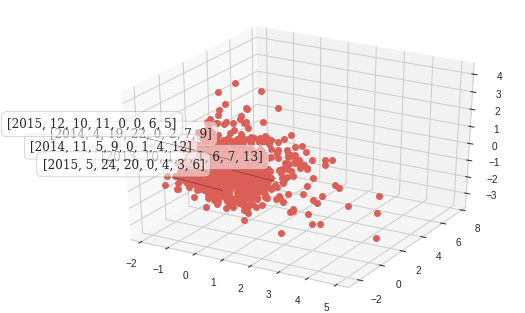

In [13]:
ht.plot(ymd_cycle,'o',normalize='across',labels=labels)

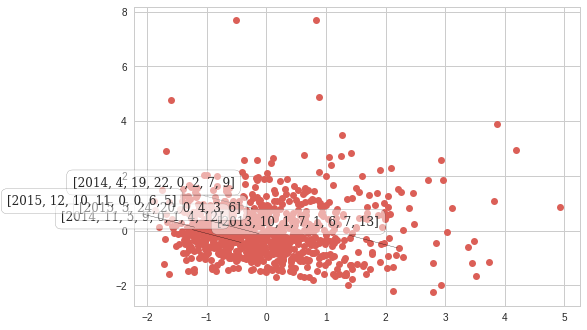

In [14]:
ht.plot(ymd_cycle,'o',normalize='across',labels=labels,ndims=2)

#### version split by month

In [ ]:
ht.plot(ymd_cycle,'o',group=list((ymd_cycle.reset_index())['month_DateTime1']),normalize='across',animate=Fa,chemtrails=True,duration=300,rotations=10,zoom=3)

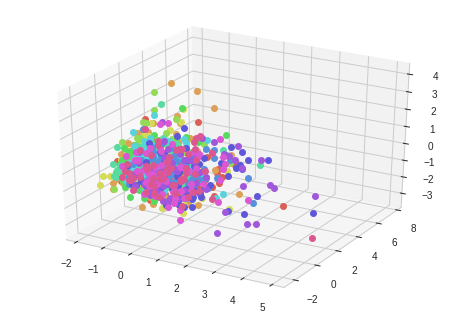

In [15]:
ht.plot(ymd_cycle,'o',group=list((ymd_cycle.reset_index())['month_DateTime1']),normalize='across')

In [ ]:
ht.plot(ymd_cycle,'-', palette='RdBu_r',normalize='across',animate=True,chemtrails=True,duration=300,rotations=10,zoom=3)

In [ ]:
ht.plot(ymd_cycle,'o',group=list((ymd_cycle.reset_index())['month_DateTime1']),normalize='across',animate=True,chemtrails=True,duration=300,rotations=10,zoom=3)
# ,tail_duration=0.3,legend=labels,zoom=2')

In [ ]:
# ht.plot(train_X,'o',group=list(train_ori['OutcomeType']),normalize='across',
#         chemtrails=True,animate=True,tail_duration=0.3,legend=labels,zoom=2)
ht.plot(ymd_cycle,'-',normalize='across',
        chemtrails=True,animate=True,tail_duration=0.3,legend=labels,zoom=2,save_path='austin2.mp4')

In [21]:
%%HTML
<video width="480" height="320" controls>
  <source src="hyperplots/austin2.mp4" type="video/mp4">
</video>

from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=3)
reduced_data_TSNE = TSNE_model.fit_transform(ht.tools.df2mat(train_X))
ht.plot(reduced_data_TSNE,'o', group=list(train_ori['OutcomeType']), legend=labels)


#### Covert Result to Gif

##### 2 line
Ref [create-animated-gif-from-mp4-video-via-command-line](https://askubuntu.com/questions/648603/create-animated-gif-from-mp4-video-via-command-line)

```bash
ffmpeg -i video.mp4  -r 5 'frames/frame-%03d.jpg'
```

-r 5 stands for FPS value
    for better quality choose bigger number
    adjust the value with the -delay in 2nd step
    to keep the same animation speed

%03d gives sequential filename number in decimal form

```bash
cd frames
convert -delay 20 -loop 0 *.jpg myimage.gif
```

-delay 20 means the time between each frame is 0.2 seconds
   which match 5 fps above.
   When choosing this value
       1 = 100 fps
       2 = 50 fps
       4 = 25 fps
       5 = 20 fps
       10 = 10 fps
       20 = 5 fps
       25 = 4 fps
       50 = 2 fps
       100 = 1 fps
       in general 100/delay = fps

-loop 0 means repeat forever

##### 1 line

```bash
ffmpeg -i input.mp4 -vf scale=320:-1 -r 10 -f image2pipe -vcodec ppm - | \
  convert -delay 5 -loop 0 - output.gif
# OR
convert input.mp4 rpi2-bare-metal-blink.gif
```


In [14]:
#ffmpeg -i hyperplots/year_month_cycle.mp4  -r 5 'frames/frame-%03d.jpg'
!convert hyperplots/year_month_day_cycle.mp4 year_month_day_cycle.gif

^C


### Conclusion

There are 3 plots being shown above.

1. cycle plot by year-month-day
2. cycle plot by year-month
3. row plot colored by the Label classes

The 1 and 2 plotd sugested that there is no timeseries infomation we can get from. They are so ramdom.

The 3 plot shown some zones, some teritories belong to each class, so we could just use tradition method might be enough.

We are not going to do simulation on this datasets. To obtain additional model we will find another way around.



# MODEL

## Data preparation

In [10]:
maindf = pd.read_csv('datasets/hand_clean.csv', encoding='latin-1')

/Users/heim/anaconda3/envs/35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (0,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create one more features

In [11]:
maindf['HasName'] = maindf['Name'].apply(lambda x: True if x !='Unknown' else False)

maindf['Name'] = maindf['Name'].apply(lambda x: x.lower())

# maindf['Name'] = maindf['Name'].apply(lambda x: np.nan if x == 'unknown' else x)

maindf['Color'] = maindf.apply(lambda row: "{} {}".format(row['PrimaryColor'] ,row['SecondaryColor']),axis=1)

maindf.Color = maindf['Color'].apply(lambda x: x.lower())

# maindf['Name'] = maindf['Name'].apply(lambda x: np.nan if x == 'unknown' else x)

maindf['Color'] = maindf.apply(lambda row: "{} {}".format(row['PrimaryColor'] ,row['SecondaryColor']),axis=1)

maindf.Color = maindf['Color'].apply(lambda x: x.lower())

### The rest

In [12]:
COLUMNS = ['AnimalID', 'AnimalType', 'Breed1', 'Hair', 'Breed2', 'BreedMix',
       'PrimaryColor', 'SecondaryColor', 'Patterns', 'Intactness', 'Name',
       'NameRank', 'OutcomeSubtype', 'OutcomeType', 'Sex', 'AgeuponOutcomeDay',
       'AgeType', 'Month', 'DayInWeek', 'PartsOfDay', 'HasName']
CATEGORICAL_COLUMNS = ['AnimalType','BreedMix','Breed1','Hair', 'PrimaryColor','Patterns', 'Intactness', 'HasName', 
                       'PartsOfDay', 'DayInWeek', 'Month','AgeType', 'Sex']
CONTINUOUS_COLUMNS = ['AgeuponOutcomeDay']
TEXTUAL_COLUMNS = ['Name','Breed1','Breed2','PrimaryColor','SecondaryColor', 'Patterns']

TARGET_COLUMNS = [ 'OutcomeSubtype', 'OutcomeType']
META_COLUMNS = ['AnimalID', 'NameRank','Breed2','SecondaryColor','Name']

simple_X = maindf.drop(META_COLUMNS + TARGET_COLUMNS, axis=1)
simple_X = pd.get_dummies(simple_X,columns=CATEGORICAL_COLUMNS)

simple_Y = maindf[TARGET_COLUMNS]
simple_Y = pd.get_dummies(simple_Y)

simple_meta = maindf[META_COLUMNS]

maindf.OutcomeType.unique()

le = LabelEncoder()
le.fit(maindf[maindf.OutcomeType.notnull()].OutcomeType)
le.classes_

fulltrain_X = simple_X[maindf.OutcomeType.notnull()]
fulltrain_Y = simple_Y[maindf.OutcomeType.notnull()]
fulltrain_Y_le = le.transform(maindf[maindf.OutcomeType.notnull()].OutcomeType)

sample_X = fulltrain_X.sample(1000)
sample_Y = fulltrain_Y.loc[sample_X.index,:]

train_X,valid_X,train_Y,valid_Y, train_Y_le, valid_Y_le = train_test_split(fulltrain_X,fulltrain_Y,fulltrain_Y_le,test_size=0.1,random_state=32)

test_X = simple_X[maindf.OutcomeType.isnull()]
test_Y = simple_Y[maindf.OutcomeType.isnull()]


test_meta = simple_meta[maindf.OutcomeType.isnull()]

INPUT_DIM = 314

## TEAPOT

**TPOT** is a Python tool that automatically creates and optimizes machine learning pipelines using genetic programming.
![](Image/tpot.png)

Here is what **TPOT** does.. TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data.
![](Image/tpotdi.png)

We want to try something new, we use TPOT for genetic algorithm.

In [43]:
GA_model = TPOTClassifier(generations=5, population_size=20,mutation_rate=0.9, crossover_rate=0.1,verbosity=2)

In [44]:
GA_model.fit(train_X.values,train_Y_le) #train_Y_le is numpy array already

Optimization Progress:  33%|███▎      | 40/120 [2:07:24<2:38:10, 118.63s/pipeline]

Generation 1 - Current best internal CV score: 0.6748421604030671


Optimization Progress:  50%|█████     | 60/120 [2:15:07<42:52, 42.88s/pipeline]   

Generation 2 - Current best internal CV score: 0.6748421604030671


Optimization Progress:  67%|██████▋   | 80/120 [2:23:26<16:17, 24.43s/pipeline]

Generation 3 - Current best internal CV score: 0.6748421604030671


Optimization Progress:  83%|████████▎ | 100/120 [2:28:40<05:24, 16.22s/pipeline]

Generation 4 - Current best internal CV score: 0.6748421604030671


Generation 5 - Current best internal CV score: 0.6748421604030671

Best pipeline: RandomForestClassifier(ZeroCount(input_matrix), RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=DEFAULT, RandomForestClassifier__max_features=0.25, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=100)


In [45]:
print(GA_model.score(valid_X.values, valid_Y_le))  #valid_Y_le is numpy array already
GA_model.export('GA_best_model_pipeline.py')

0.674148896371


In [46]:
GA_model.predict_proba(test_X.values)

array([[  6.61515302e-02,   0.00000000e+00,   5.39485394e-02,
          1.26512788e-01,   7.53387143e-01],
       [  7.76031776e-01,   2.77777778e-04,   1.79222207e-03,
          1.77393857e-01,   4.45043676e-02],
       [  1.68179392e-01,   0.00000000e+00,   2.38313103e-03,
          1.95734968e-01,   6.33702509e-01],
       ..., 
       [  0.00000000e+00,   1.56918082e-03,   4.11006088e-02,
          2.13203463e-03,   9.55198176e-01],
       [  4.90117189e-01,   2.40740741e-03,   1.82234304e-02,
          4.23708723e-01,   6.55432502e-02],
       [  7.65233429e-02,   2.38095238e-04,   1.61148678e-01,
          4.65761023e-01,   2.96328861e-01]])

In [47]:
df_submit = pd.DataFrame(_,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
a.drop(['index'],axis=1,inplace=True)
a.rename(columns={'AnimalID':'ID'},inplace=True)
a.to_csv('submits/tpot 5 20.csv', index=False)

## RandomForest

In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(train_X,train_Y.iloc[:,-5:])
model_rf.predict_proba(test_X.iloc[0:1,:])
df_submit = pd.DataFrame(_,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
a.drop(['index'],axis=1,inplace=True)
a.rename(columns={'AnimalID':'ID'},inplace=True)
a.to_csv('submits/tpot 5 20.csv', index=False)

## XGBoost

XGBoost is used for supervised learning problems
![](Image/xgboost.png)
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model. This is a tutorial on gradient boosted trees, and most of the content is based on these slides by the author of xgboost.

In [30]:
model_xgb = xgb.XGBClassifier(objective='multi:softmax')

In [ ]:
Training

In [32]:
model_xgb.fit(train_X, train_Y_le,eval_metric='logloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Prediction

In [33]:
model_xgb.predict_proba(test_X)

array([[ 0.0631774 ,  0.00437598,  0.03805678,  0.24815251,  0.64623731],
       [ 0.71163774,  0.00158947,  0.01162452,  0.23473668,  0.04041154],
       [ 0.3806577 ,  0.00439657,  0.02562449,  0.11442328,  0.47489795],
       ..., 
       [ 0.00787238,  0.00828443,  0.09950516,  0.01203393,  0.87230408],
       [ 0.55221218,  0.00162243,  0.02356715,  0.38111866,  0.04147961],
       [ 0.09931849,  0.00504126,  0.11606991,  0.6198222 ,  0.15974812]], dtype=float32)

In [34]:
df_submit = pd.DataFrame(_,columns=['Adoption', "Died", "Euthanasia", "Return_to_owner", 'Transfer'])
a = pd.concat([test_meta['AnimalID'].reset_index(),df_submit.reset_index()],axis=1)
a.drop(['index'],axis=1,inplace=True)
a.rename(columns={'AnimalID':'ID'},inplace=True)
a.to_csv('submits/xgb.csv', index=False)

## Deep Mano: a deep learning model

### introduction

![](Image/neural_network.png)
What is a neural network? A neural network is a “connectionist” computational system. The computational systems we write are procedural; a program starts at the first line of code, executes it, and goes on to the next, following instructions in a linear fashion. A true neural network does not follow a linear path. Rather, information is processed collectively, in parallel throughout a network of nodes (the nodes, in this case, being neurons). - Daniel Shiffman

### the simplest neural network

In [13]:
model = Sequential()
model.add(Dense(50, input_dim=314))
#     if dropout > 0: model.add(Dropout(dropout))
#     model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dense(5))
model.add(Activation('softmax'))


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                15750     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 16,005
Trainable params: 16,005
Non-trainable params: 0
_________________________________________________________________


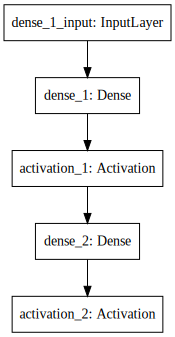

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### multitask/trasfer learning neural network

The concept was introduced in Marc'Aurelio's CVPR 2014 tutorial(https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxsc3ZydHV0b3JpYWxjdnByMTR8Z3g6Njg5MmZkZTM1MDhhZWNmZA), 92page, or as below:
![](https://camo.githubusercontent.com/9b5b091d632c5b923b706016ca15ee56e70c9958/687474703a2f2f322e62702e626c6f6773706f742e636f6d2f2d74736736742d63547857302f56626e31416c51776e72492f414141414141414143546b2f487a5548794e62547478492f73313630302f53637265656e25324253686f74253242323031352d30372d33302532426174253242253235453125323538342532353842253235453125323538352532354139253235453125323538342532353932253235453125323538352532354145253242362e35352e30312e706e67)

In [15]:
a = Input(shape=(INPUT_DIM,))
b = Dense(100,activation='relu')(a)
# b = Dense(50,activation='relu')(b)
# c = Dense(100,activation='relu')(b)
# base_model = Model(inputs=a, outputs=c)

outcome = Dense(5,activation='softmax', name='main')(b)
model_outcomeOnly = Model(inputs=a, outputs=outcome)

subTypeOutcome = Dense(16,activation='softmax', name='subtype')(b)
model_outcomeWsubType = Model(inputs=a, outputs=[subTypeOutcome,outcome])
model_outcomeWOsubType = Model(inputs=a, outputs=outcome)

model_outcomeWsubType.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
model_outcomeWOsubType.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss=['binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

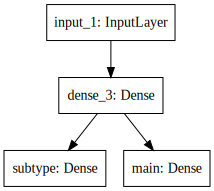

In [16]:
SVG(model_to_dot(model_outcomeWsubType).create(prog='dot', format='svg'))

### Multitask + Embedding

In [4]:
BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.6B/'

EMBEDDING_DIM = 50
MAX_NAME = 300
MAX_COLOR = 100

In [ ]:
glove = pd.read_csv(GLOVE_DIR + 'glove.6B.50d.txt',sep=' ', quoting=csv.QUOTE_NONE,header=['word'].extend(list(range(50))) )

glove.set_index(0,inplace=True)

In [17]:
p=0.4
a = Input(shape=(INPUT_DIM,), name='simpleFeature')
inp = Input(shape=(3,), name='color')
inp_name = Input(shape=(1,), name='name')
# a_name = Embedding(MAX_NAME, EMBEDDING_DIM,weights=[embedding_matrix],input_length=1,trainable=True)(inp_name)
a_name = Embedding(MAX_NAME, EMBEDDING_DIM,input_length=1,trainable=True)(inp_name)
# a_color = Embedding(30, EMBEDDING_DIM, weights=[embedding_matrix_color],input_length=3,trainable= True)(inp)
a_color = Embedding(30, EMBEDDING_DIM,input_length=3,trainable= True)(inp)
s = Flatten()(a_name)
# s = Dense(50,activation='relu')(s)
s1 = Flatten()(a_color)
# s1 = Dense(10,activation='relu')(s1)

m = merge([s,a,s1], 'concat')
s = Dense(100, activation='relu')(m)
s = BatchNormalization()(s)
s = Dropout(p)(s)
b = Dense(50,activation='relu')(s)
b = BatchNormalization()(b)
b = Dropout(p/2)(b)
b = Dense(50,activation='relu')(b)
b = BatchNormalization()(b)
b = Dropout(p/2)(b)
# b = Dense(50,activation='relu')(b)
# c = Dense(100,activation='relu')(b)
# base_model = Model(inputs=a, outputs=c)

outcome = Dense(5,activation='softmax', name='main')(b)
# model_outcomeOnly = Model(inputs=a, outputs=outcome)

subTypeOutcome = Dense(16,activation='softmax', name='subtype')(b)
model_outcomeWsubType = Model(inputs=[inp_name,a,inp], outputs=[subTypeOutcome,outcome])
# model_outcomeWOsubType = Model(inputs=a, outputs=outcome)

model_outcomeWsubType.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
# model_outcomeWOsubType.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss=['binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

/Users/heim/anaconda3/envs/35/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/heim/anaconda3/envs/35/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


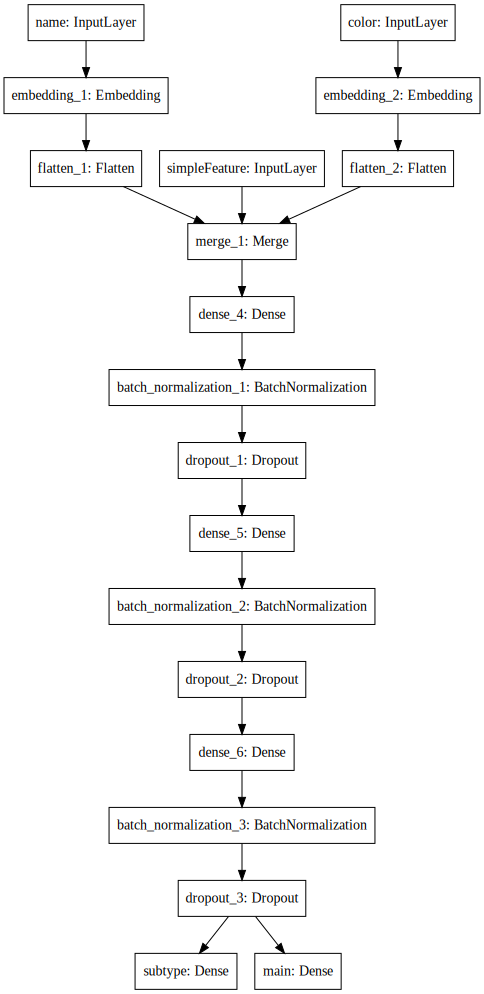

In [18]:
SVG(model_to_dot(model_outcomeWsubType).create(prog='dot', format='svg'))

# Result, Disscussion & Acheivement

The table shown below are the results decribed in **Logloss** value which is calculated by Kaggle after submitted on website. We have tested on both **Clean** and ** Dirty** dataset.

**Dirty**: The original dataset

**Clean**: Preprocessed dataset

Model | Logloss | Dataset
------------ | ------------- | -------------
Logistic Regression | 0.84646 | Dirty
Simple Neural Network | 0.88797 | Dirty
Multitask Neural Network | 0.86943 | Dirty
Simple Neural Network | 0.83285 | Clean
2 Hidden Layers Neural Network | 0.88984 | Clean
1 Hidden Layers Neural Network with Dropout | 0.90777 | Clean
Multitask Neural Network | 0.96583 | Clean
TPOT | 0.79338 | Clean
XGBoost | 0.80354 | Clean
Multitask Neural Network with Embbeding | 0.84423 | Clean



## Here is the list of what we got

### Multitask Neural Network beats Simple/Hidden Layer Neural Neteork

### Neural Network requires lots and lots of hyperparameter tuning
> no time will be enough

### TPOT: a genetic algorythm just beats all.

### Multitask Neural Network with Embbeding enable us to turn throw-away textual features like name, color into more powerful model